In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

import seaborn as sns
sns.set_context('paper', font_scale = 1.5)
sns.color_palette('colorblind')

import h5py

import corner

#for approximating GW likelihood

from scipy.stats import gaussian_kde
from jaxinterp2d import interp2d

#for numpyro sampling

from jax import random
import numpyro
from numpyro.infer import MCMC, NUTS

#for calculating rates from GC models
import GC_rates

In [2]:
#read in GC model data
GC_data = GC_rates.read_data()

#read in GW population posterior
#use the GW likelihood by dividing posterior by the prior

with h5py.File('GW_dynrate_z0_z1.h5', 'r') as inp:
    GW_R0_post = np.array(inp['dyn_rate_z0'])
    GW_R1_post = np.array(inp['dyn_rate_z1'])
    GW_R0_prior = np.array(inp['dyn_rate_z0_prior'])
    GW_R1_prior = np.array(inp['dyn_rate_z1_prior'])

In [3]:
#define approximate GW likelihood
GW_R0R1_post = np.row_stack((np.log(GW_R0_post), np.log(GW_R1_post)))
GW_R0R1_joint_kde = gaussian_kde(GW_R0R1_post)

GW_R0R1_prior = np.row_stack((np.log(GW_R0_prior), np.log(GW_R1_prior)))
GW_R0R1_prior_joint_kde = gaussian_kde(GW_R0R1_prior)

logR0_grid = jnp.linspace(jnp.log(0.1), jnp.log(1000), 1000)
logR1_grid = jnp.linspace(jnp.log(0.1), jnp.log(1000), 1000)

R0p, R1p = jnp.meshgrid(logR0_grid, logR1_grid, indexing = "ij")

GW_R0R1_post_kde_grid = GW_R0R1_joint_kde.evaluate(np.row_stack((R0p.flatten(), R1p.flatten())))
GW_R0R1_prior_kde_grid = GW_R0R1_prior_joint_kde.evaluate(np.row_stack((R0p.flatten(), R1p.flatten())))


def GW_logpost(R0,R1):
    '''
    R0: BBH dynamics rate at z = 0
    R1: BBH dynamics rate at z = 1
    Returns the GW log likelihood at R0, R1
    '''
    return interp2d(jnp.log(R0), jnp.log(R1), logR0_grid, logR1_grid, jnp.log(GW_R0R1_post_kde_grid.reshape(1000,1000)) - jnp.log(GW_R0R1_prior_kde_grid.reshape(1000,1000)))

In [4]:
sigma_dex = 0.5 #spread in metallicity distribution at each redshift
Zsun = 0.02 #solar metallicity
logMlo = 4 #minimum GC mass is 10^4 Msun
logMhi = 8 #maximum GC mass is 10^8 Msun
dNdV0 = 2.31e9 #number density of evolved clusters *today* in Gpc^-3, neglecting cluster evaporation
#note we are only considering clusters between 10^4 and 10^8 Msun.
#While the mass distribution may extend down to 100 Msun, we will consider the contribution from these light clusters to be part of the "cluster evaporation" term.

def loglike(z_gc, a, b, mu_rv, sigma_rv, beta, logMstar0, logf_disrupted_cluster):
    
    R0 = GC_rates.merger_rate_at_z_pop(
        GC_data, 0, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, logMlo, logMhi)
    R1 = GC_rates.merger_rate_at_z_pop(
        GC_data, 1, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, logMlo, logMhi)
    return GW_logpost(R0, R1)

def prior(z_gc_bounds = [0, 8], a_bounds = [1,5], b_bounds = [1,5], 
          mu_rv_bounds = [0.5, 4], sigma_rv_bounds = [1, 3], 
          beta_bounds = [-3, 3], logMstar0_bounds = [6, 7],
          logf_disrupted_cluster_bounds = [0, 2], 
          fixed_mass_dist = False, beta_fixed = -2, logMstar0_fixed = 6.3,
         fixed_radius_dist = False, mu_rv_fixed = 2, sigma_rv_fixed = 2):
    
    cluster_params = dict()
    
    cluster_params['z_gc'] = numpyro.sample('z_gc', numpyro.distributions.Uniform(low = z_gc_bounds[0], high = z_gc_bounds[1]))
    cluster_params['a'] = numpyro.sample('a', numpyro.distributions.Uniform(low = a_bounds[0], high = a_bounds[1]))
    cluster_params['b'] = numpyro.sample('b', numpyro.distributions.Uniform(low = b_bounds[0], high = b_bounds[1]))
    
    if fixed_radius_dist:
        cluster_params['mu_rv'] = numpyro.deterministic('mu_rv', mu_rv_fixed)
        cluster_params['sigma_rv'] = numpyro.deterministic('sigma_rv', sigma_rv_fixed)
        
    else:
        cluster_params['mu_rv'] = numpyro.sample('mu_rv', numpyro.distributions.Uniform(low = mu_rv_bounds[0], high = mu_rv_bounds[1]))
        cluster_params['sigma_rv'] = numpyro.sample('sigma_rv', numpyro.distributions.Uniform(low = sigma_rv_bounds[0], high = sigma_rv_bounds[1]))
    
    if fixed_mass_dist:
        cluster_params['beta'] = numpyro.deterministic('beta', beta_fixed)
        cluster_params['logMstar0'] = numpyro.deterministic('logMstar0', logMstar0_fixed)
        
    else:
        cluster_params['beta'] = numpyro.sample('beta', numpyro.distributions.Uniform(low = beta_bounds[0], high = beta_bounds[1]))
        cluster_params['logMstar0'] = numpyro.sample('logMstar0', numpyro.distributions.Uniform(low = logMstar0_bounds[0], high = logMstar0_bounds[1]))
    
    cluster_params['logf_disrupted_cluster'] = numpyro.sample('logf_disrupted_cluster', numpyro.distributions.Uniform(low = logf_disrupted_cluster_bounds[0], high = logf_disrupted_cluster_bounds[1]))
 
    return cluster_params


def posterior(z_gc_bounds = [0, 8], a_bounds = [1,5], b_bounds = [1,5], 
          mu_rv_bounds = [0.5, 4], sigma_rv_bounds = [1, 3], 
          beta_bounds = [-3, 3], logMstar0_bounds = [6, 7],
          logf_disrupted_cluster_bounds = [0, 2],
              fixed_mass_dist = False, beta_fixed = -2, logMstar0_fixed = 6.3,
             fixed_radius_dist = False, mu_rv_fixed = 2, sigma_rv_fixed = 2
             ):
    
    ll = loglike(**prior(z_gc_bounds, a_bounds, b_bounds, 
                         mu_rv_bounds, sigma_rv_bounds, beta_bounds,
                        logMstar0_bounds, logf_disrupted_cluster_bounds, 
                         fixed_mass_dist, beta_fixed, logMstar0_fixed, fixed_radius_dist, mu_rv_fixed, sigma_rv_fixed))
    
    numpyro.factor('loglikelihood', ll)

#### fixing the mass distribution

In [5]:
prior_sampler = MCMC(NUTS(prior), num_warmup=64000, num_samples=64000, progress_bar = True)
prior_sampler.run(random.PRNGKey(0), fixed_mass_dist = True)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 128000/128000 [02:42<00:00, 786.28it/s, 7 steps of size 6.50e-01. acc. prob=0.89]


In [6]:
prior_samples = prior_sampler.get_samples()

with h5py.File('GC_properties_prior.h5', 'w') as out:
    for n in prior_samples.keys():
        out.create_dataset(name = n, data = prior_samples[n])

In [7]:
sampler = MCMC(NUTS(posterior), num_warmup=64000, num_samples=64000, progress_bar = True)

sampler.run(random.PRNGKey(0), fixed_mass_dist = True)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 128000/128000 [26:48<00:00, 79.58it/s, 7 steps of size 4.12e-01. acc. prob=0.91]


In [8]:
samples_fixedmassdist = sampler.get_samples()
sampler.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
                       a      3.22      1.10      3.30      1.63      5.00  60260.58      1.00
                       b      2.95      1.15      2.93      1.00      4.57  69469.05      1.00
  logf_disrupted_cluster      1.32      0.28      1.35      0.87      1.77  43196.39      1.00
                   mu_rv      2.22      1.01      2.21      0.52      3.64  62261.17      1.00
                sigma_rv      2.00      0.58      2.01      1.20      3.00  64081.86      1.00
                    z_gc      4.61      2.04      4.70      1.75      8.00  55394.93      1.00

Number of divergences: 0


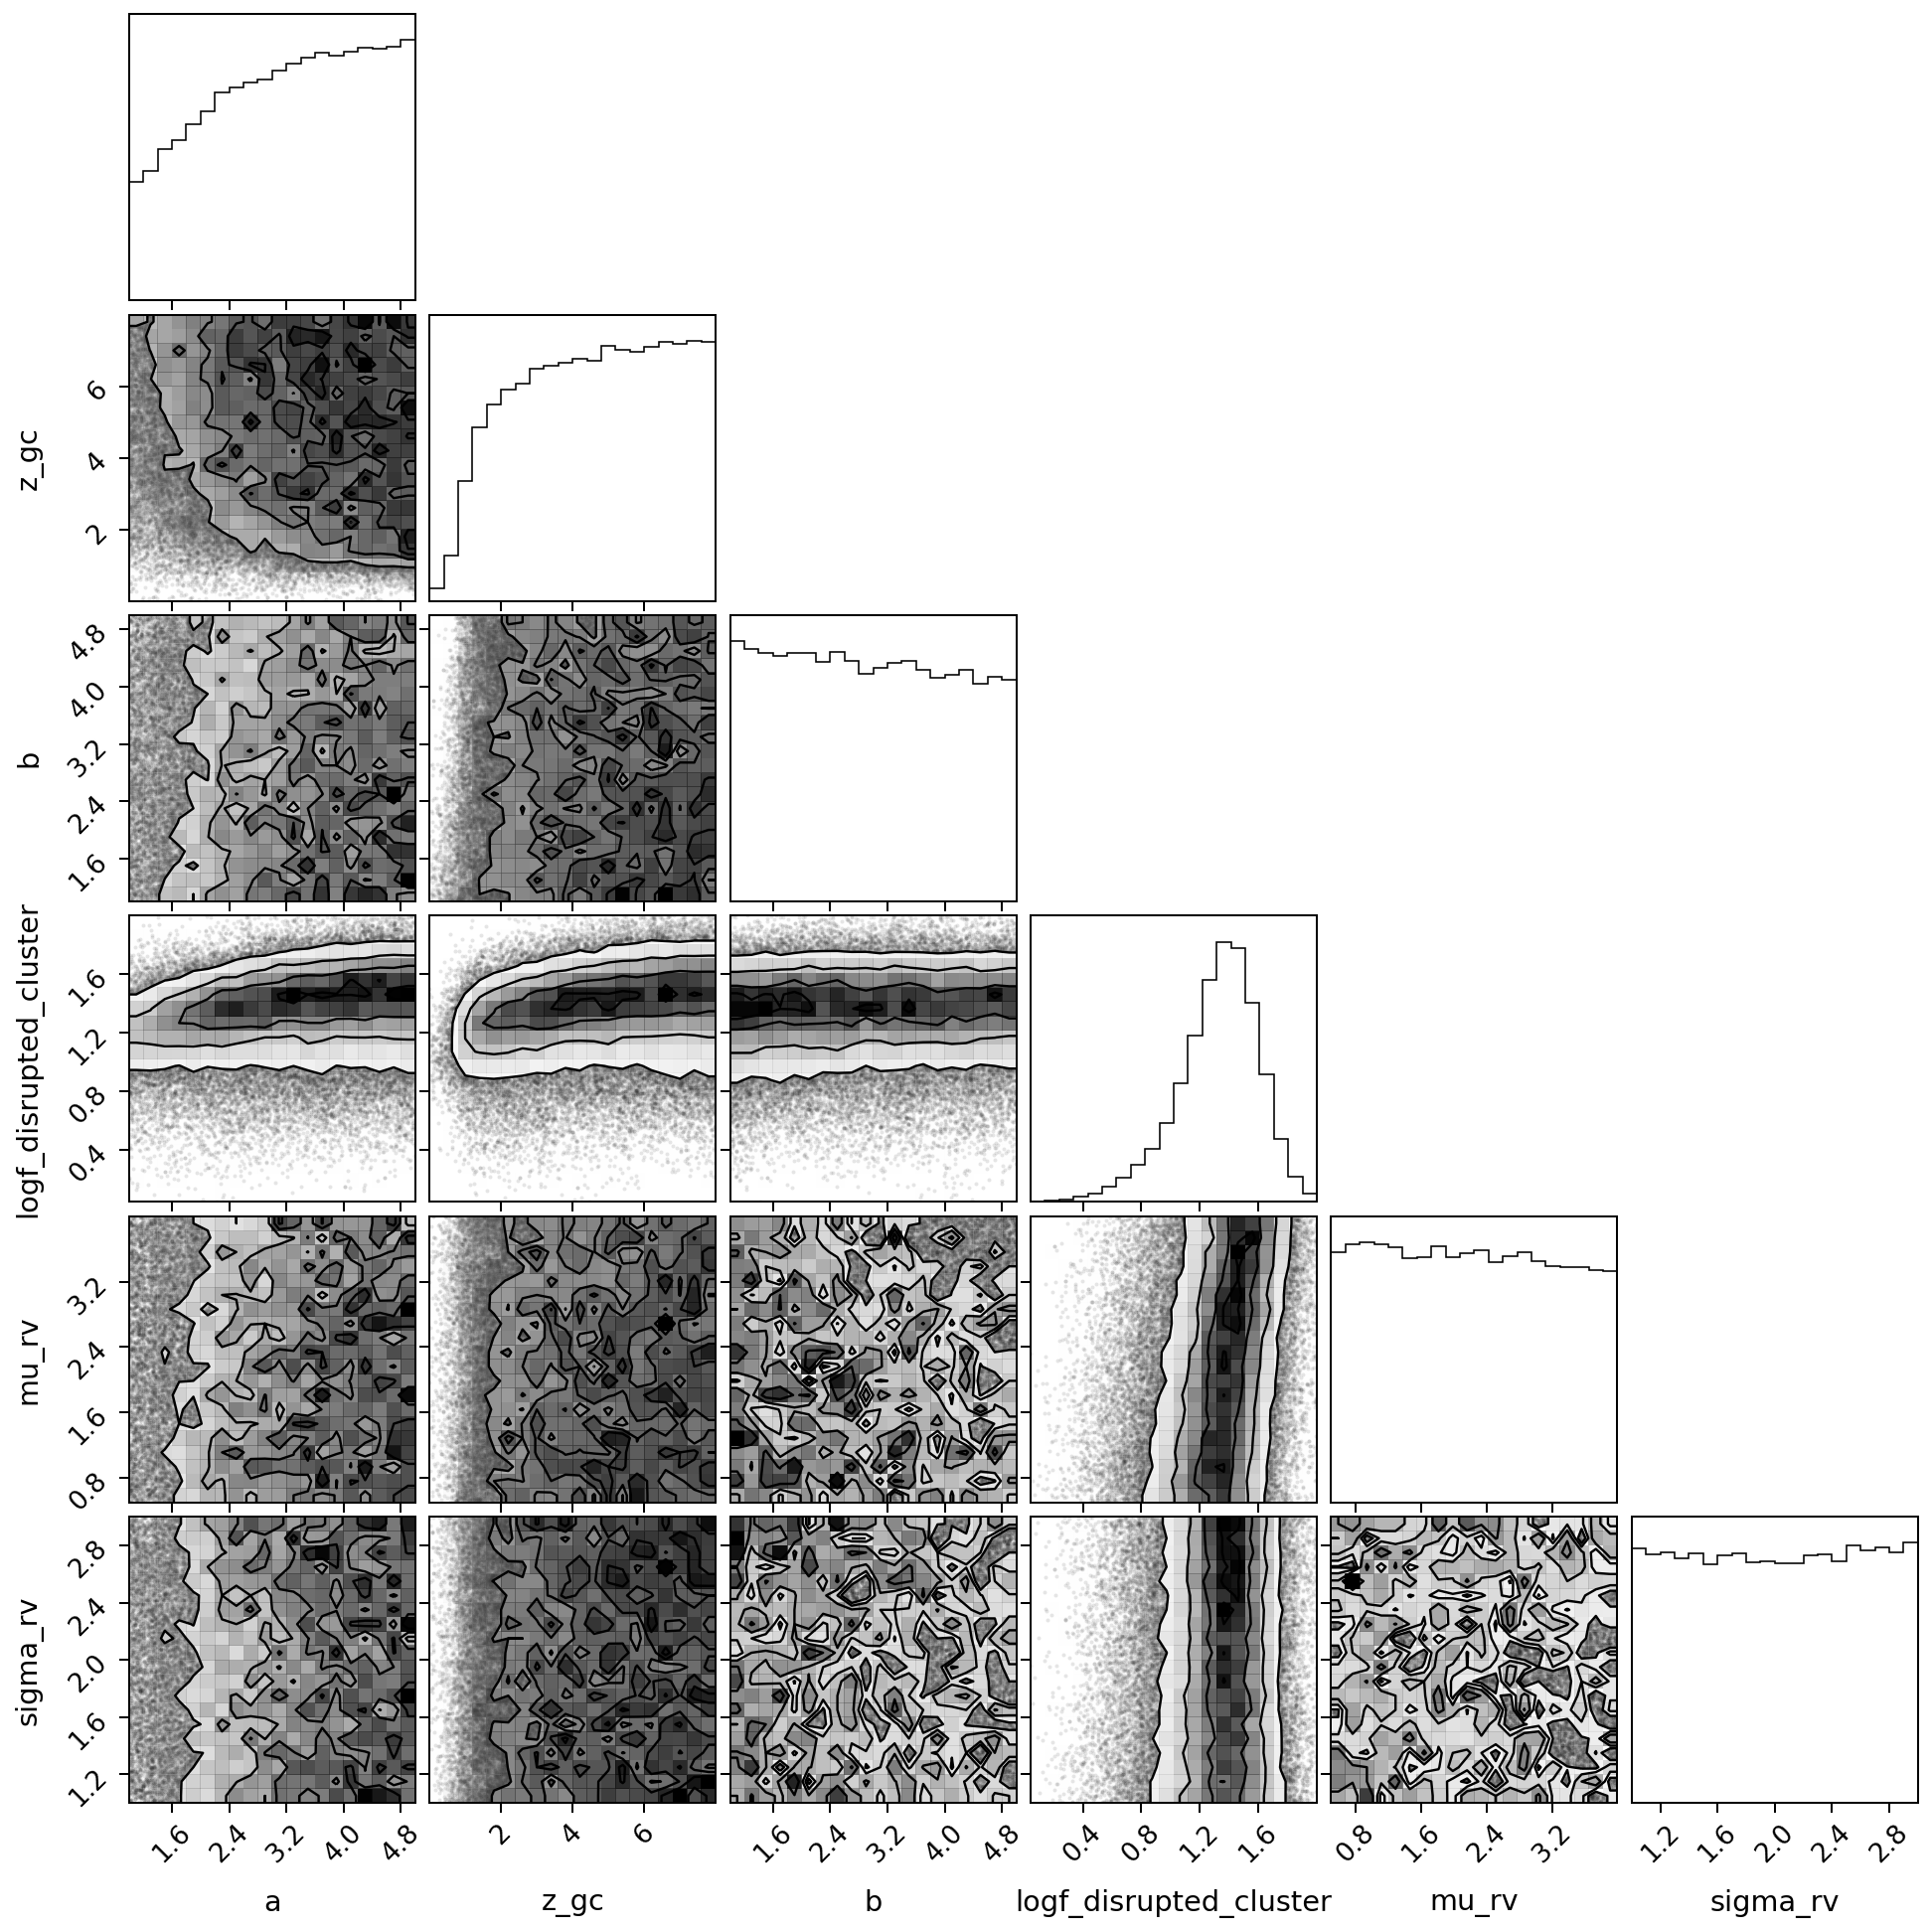

In [9]:
corner.corner(samples_fixedmassdist, var_names = ['a', 'z_gc', 'b', 'logf_disrupted_cluster', 'mu_rv', 'sigma_rv']);

In [10]:
with h5py.File('GC_properties_fixedmassdist.h5', 'w') as out:
    for n in samples_fixedmassdist.keys():
        out.create_dataset(name = n, data = samples_fixedmassdist[n])

#### fixing the radius distribution

In [11]:
sampler = MCMC(NUTS(posterior), num_warmup = 64000, num_samples=64000, progress_bar = True)

sampler.run(random.PRNGKey(0), fixed_radius_dist = True)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 128000/128000 [1:23:59<00:00, 25.40it/s, 15 steps of size 1.06e-01. acc. prob=0.93]


In [12]:
samples_fixedradiusdist = sampler.get_samples()
sampler.print_summary()


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
                       a      3.19      1.10      3.26      1.61      5.00  58116.07      1.00
                       b      2.95      1.16      2.92      1.00      4.59  56659.51      1.00
                    beta     -1.93      0.50     -1.95     -2.75     -1.12  20387.38      1.00
               logMstar0      6.46      0.29      6.44      6.00      6.88  52156.19      1.00
  logf_disrupted_cluster      1.07      0.59      1.12      0.21      2.00  26604.70      1.00
                    z_gc      4.59      2.04      4.65      1.74      8.00  49830.39      1.00

Number of divergences: 5


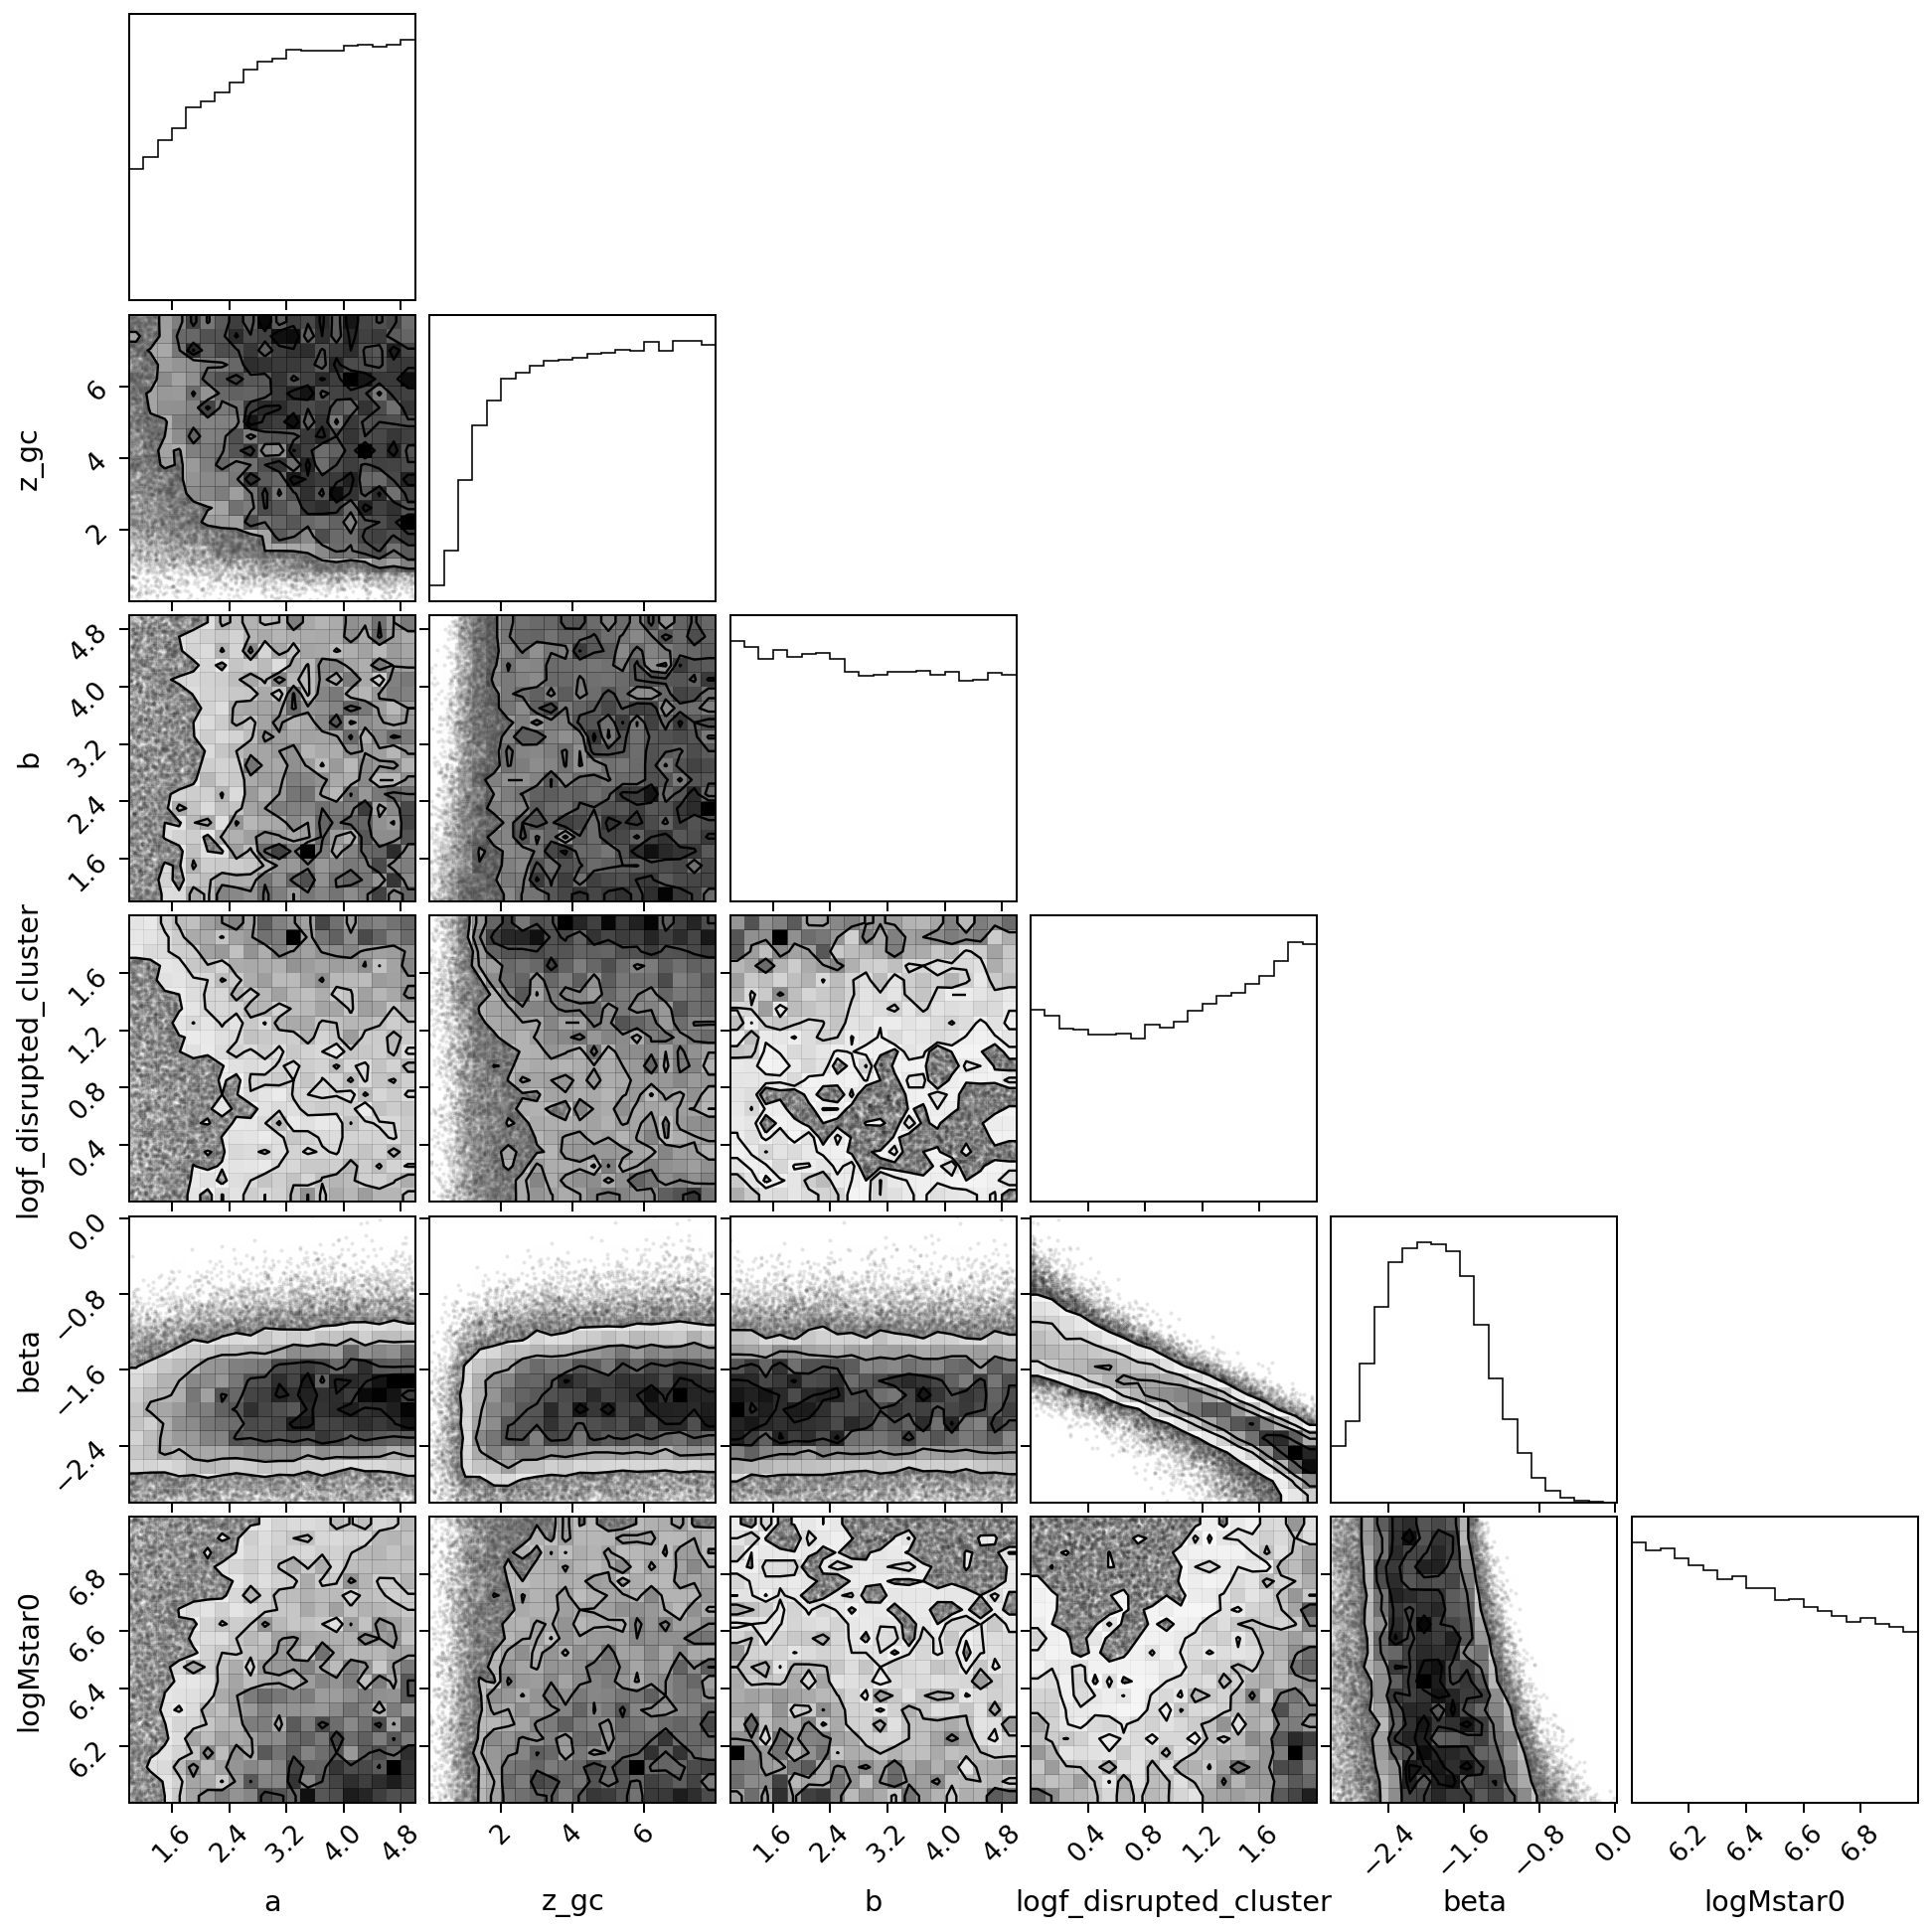

In [13]:
corner.corner(samples_fixedradiusdist, var_names = ['a', 'z_gc', 'b', 'logf_disrupted_cluster', 'beta', 'logMstar0']);

In [14]:
with h5py.File('GC_properties_fixedradiusdist.h5', 'w') as out:
    for n in samples_fixedradiusdist.keys():
        out.create_dataset(name = n, data = samples_fixedradiusdist[n])